usage: ipykernel_launcher.py [-h] [--dataset DATASET]
                             [--angle_step ANGLE_STEP]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\Nuwantha\AppData\Roaming\jupyter\runtime\kernel-v31a7c042e212240c47922eb6e6a29942fb59bab9c.json


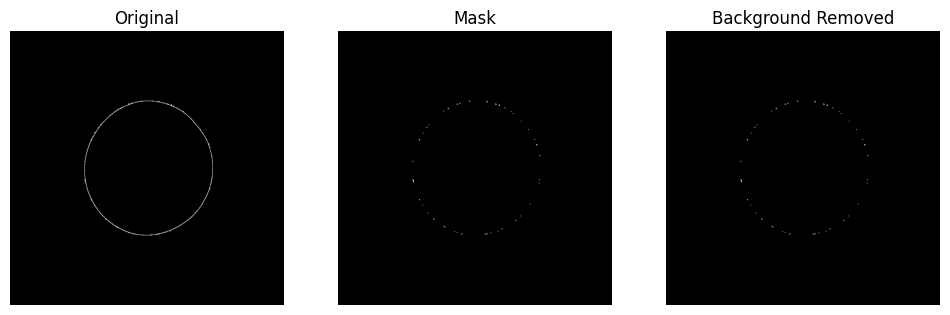

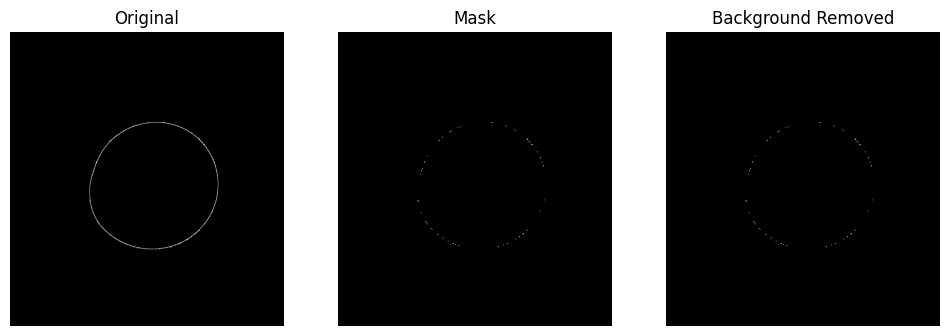

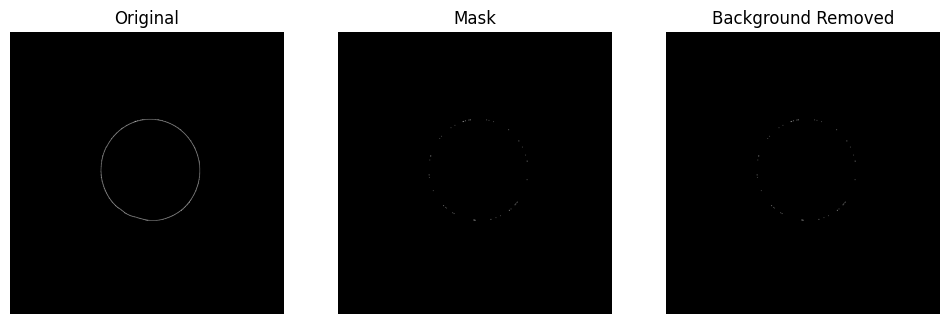

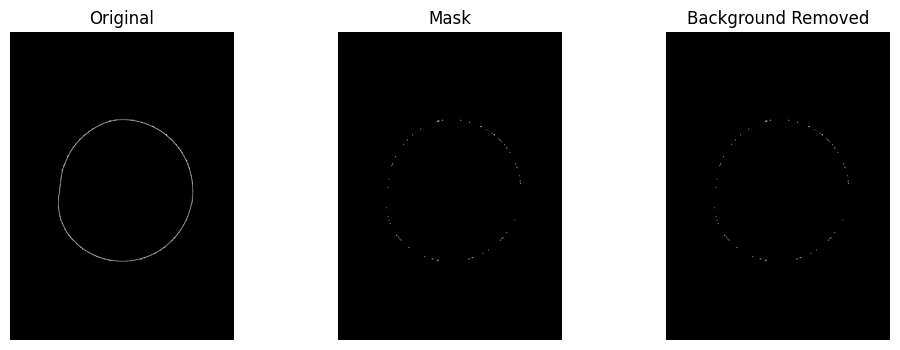

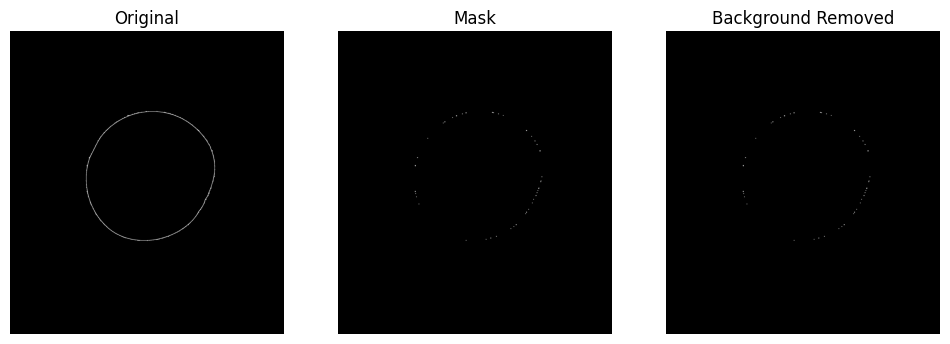

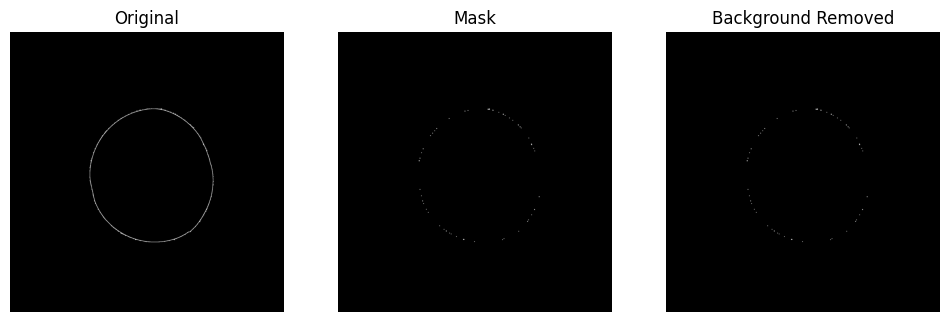

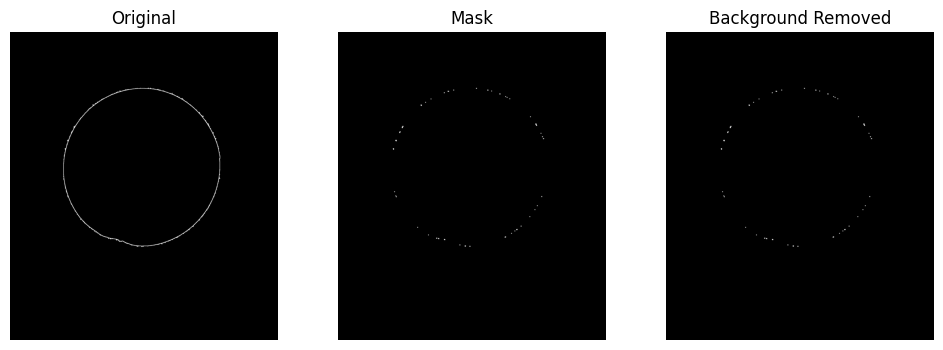

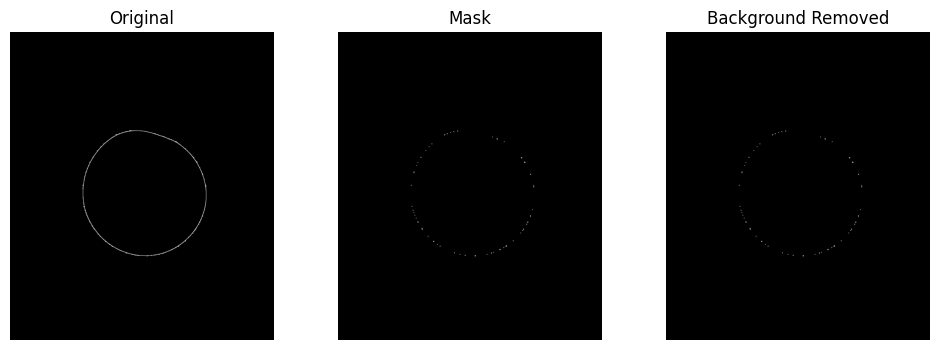

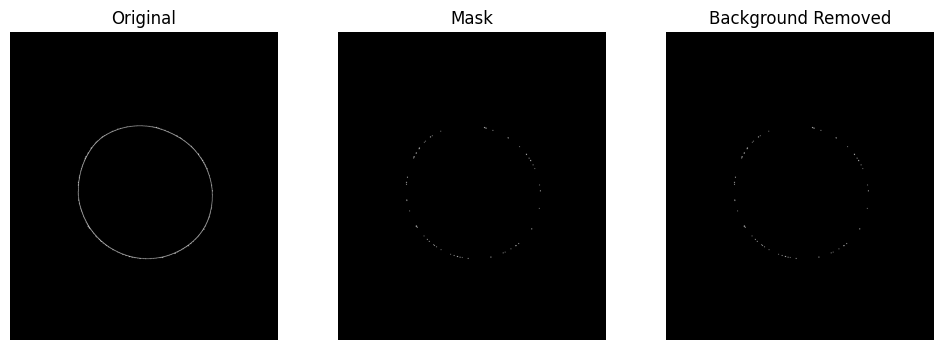

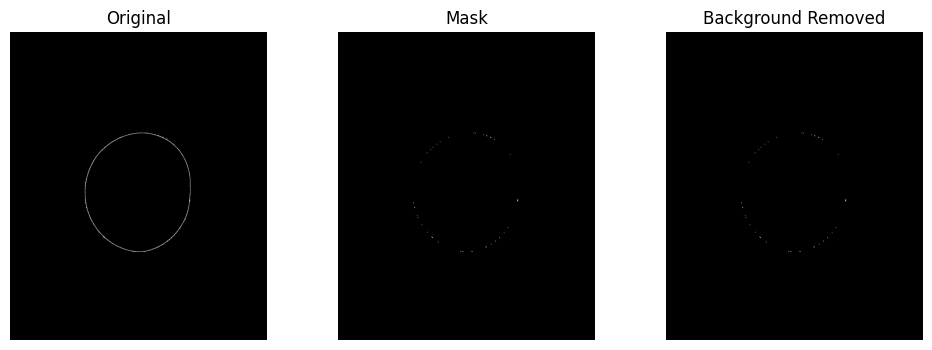

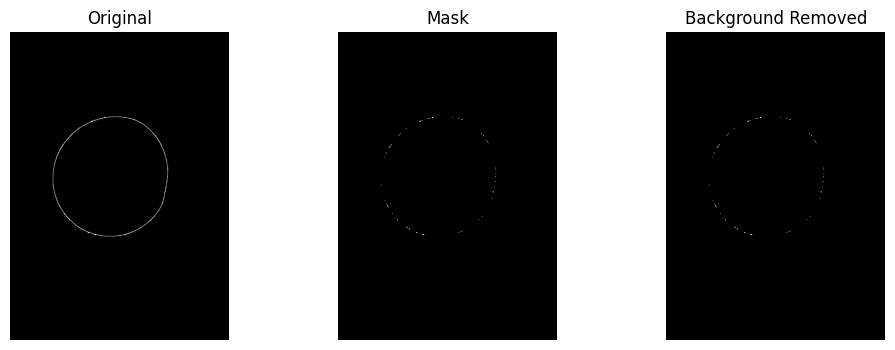

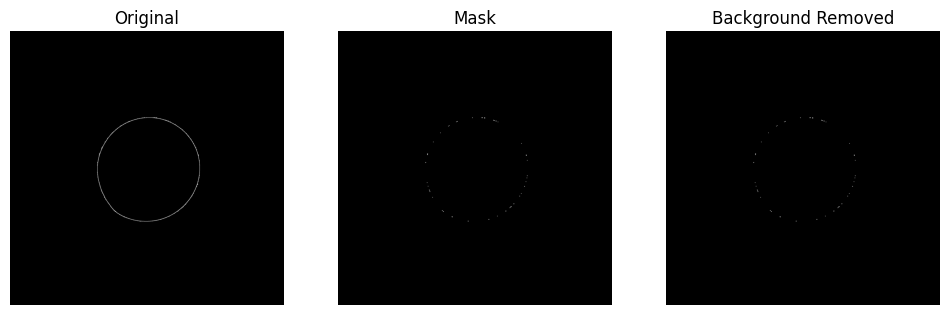

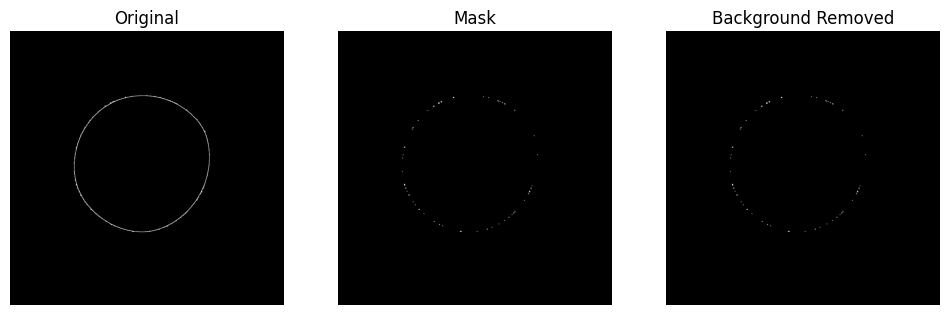

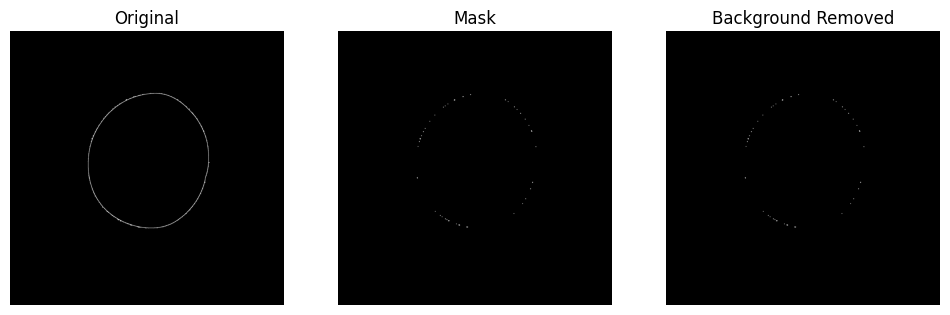

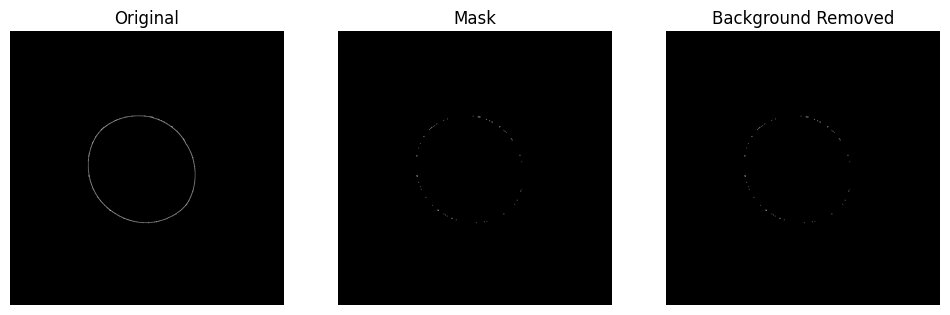

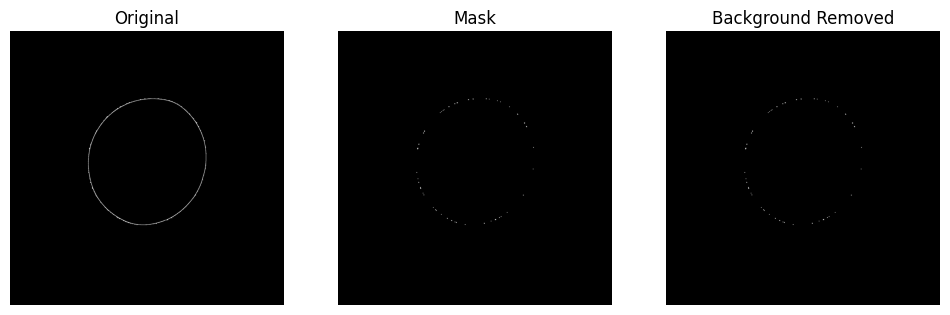

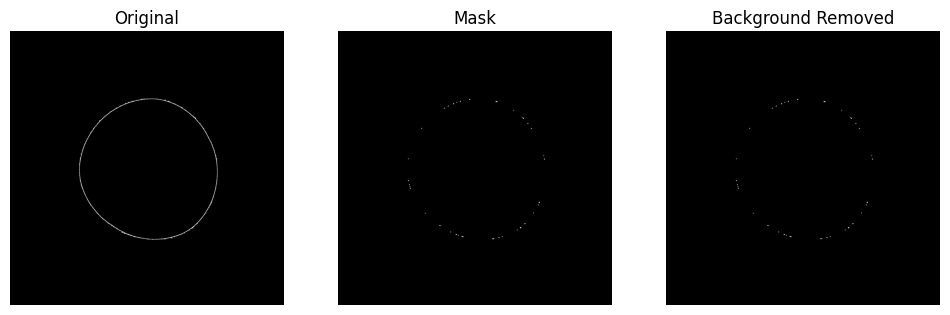

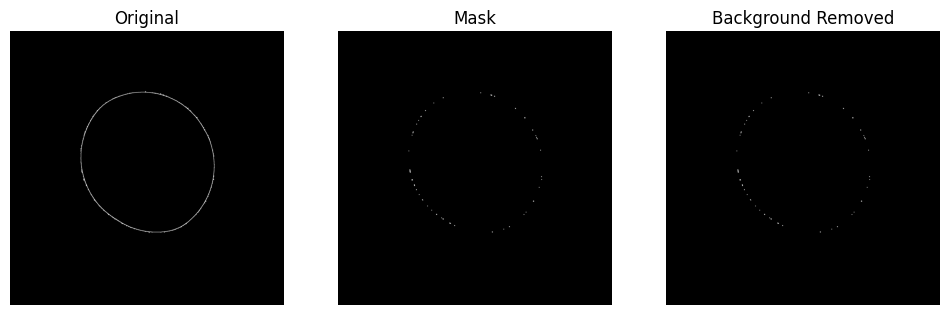

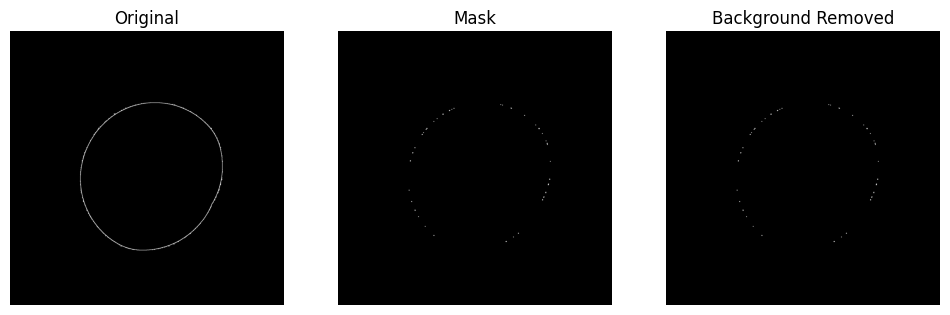

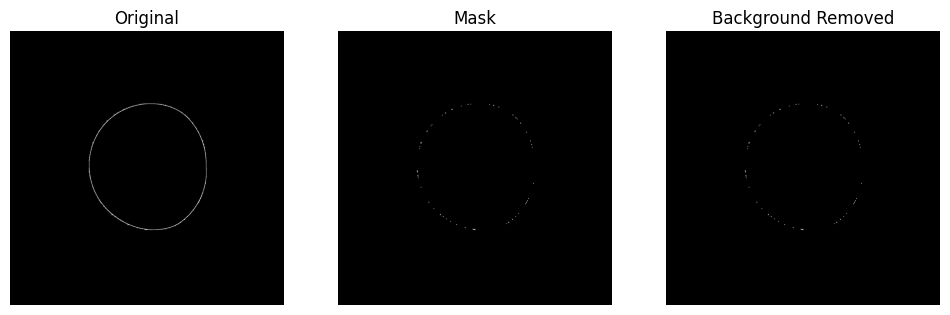

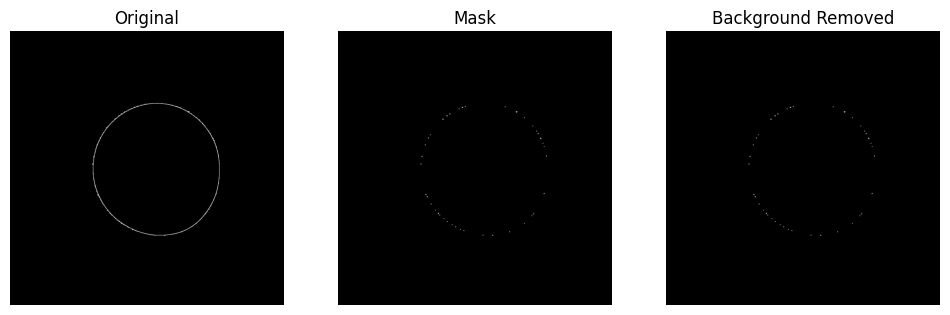

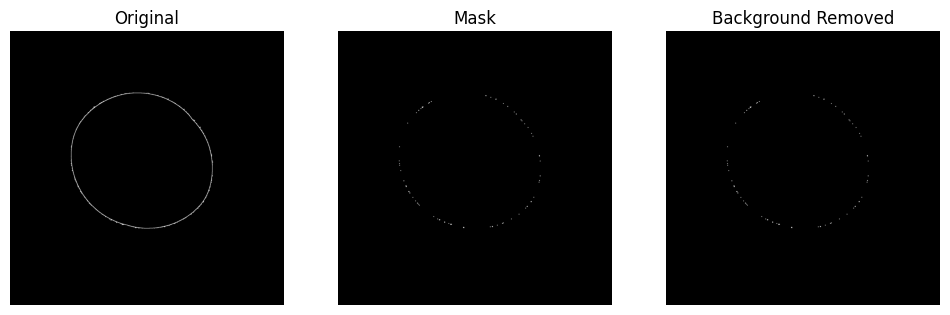

KeyboardInterrupt: 

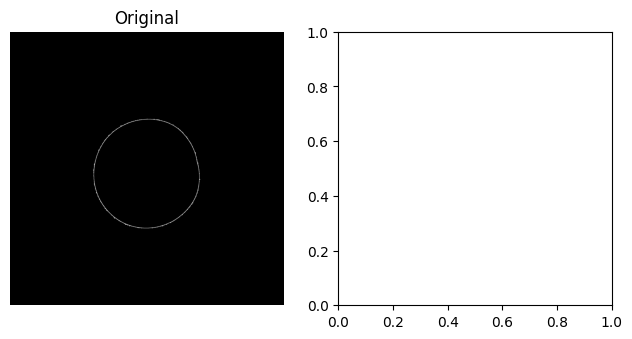

In [4]:
# pipeline.py
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import math
import matplotlib.pyplot as plt
import sys

# ---------------------- Config ----------------------
LABEL_MAP = {"defected": 0, "non_defected": 1}
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
PLOT_STEPS = True  # Set True to visualize steps (background removal, contour, radii)

# ------------------ Utility helpers -----------------
def sibling_dir(base: Path, suffix: str) -> Path:
    return base.parent / f"{base.name}_{suffix}"

def is_image(p: Path) -> bool:
    return p.suffix.lower() in IMG_EXTS

# ----------------- 1) Remove background -------------
def remove_background_bgr(img_bgr: np.ndarray):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    result = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
    return mask, result

def save_background_removed_dataset(dataset_dir: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    for label in LABEL_MAP.keys():
        in_folder = dataset_dir / label
        out_folder = out_dir / label
        out_folder.mkdir(parents=True, exist_ok=True)
        for p in sorted(in_folder.rglob("*")):
            if not p.is_file() or not is_image(p):
                continue
            img = cv2.imread(str(p))
            if img is None:
                print(f"[WARN] Cannot read {p}")
                continue
            mask, cleaned = remove_background_bgr(img)
            cv2.imwrite(str(out_folder / p.name), cleaned)
            if PLOT_STEPS:
                plt.figure(figsize=(12,4))
                plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
                plt.subplot(1,3,2); plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
                plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(cleaned, cv2.COLOR_BGR2RGB)); plt.title("Background Removed"); plt.axis("off")
                plt.show()
    print(f"[OK] Background-removed dataset -> {out_dir}")

# --------------- 2) Get circumference ----------------
def largest_external_contour(bin_img: np.ndarray):
    cnts, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return None
    return max(cnts, key=cv2.contourArea)

def save_outer_contour_dataset(input_dir: Path, output_dir: Path, draw_thickness: int = 2):
    output_dir.mkdir(parents=True, exist_ok=True)
    for label in LABEL_MAP.keys():
        in_folder = input_dir / label
        out_folder = output_dir / label
        out_folder.mkdir(parents=True, exist_ok=True)
        for p in sorted(in_folder.rglob("*")):
            if not p.is_file() or not is_image(p):
                continue
            img = cv2.imread(str(p))
            if img is None:
                print(f"[WARN] Cannot read {p}")
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            cnt = largest_external_contour(thresh)
            if cnt is None:
                print(f"[WARN] No contour in {p}")
                continue
            canvas = np.zeros_like(img)
            cv2.drawContours(canvas, [cnt], -1, (255, 255, 255), draw_thickness)
            cv2.imwrite(str(out_folder / p.name), canvas)
            if PLOT_STEPS:
                plt.figure(figsize=(6,6))
                plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
                plt.title(f"Outer Contour: {p.name}")
                plt.axis("off")
                plt.show()
    print(f"[OK] Outer-contour dataset -> {output_dir}")

# ------------- 3&4) Center & Radii -----------------
def estimate_center_from_contour(cnt: np.ndarray):
    (cx, cy), r = cv2.minEnclosingCircle(cnt)
    return float(cx), float(cy), float(r)

def ray_hit_radius(bin_img: np.ndarray, center, theta_deg: float, max_step=None) -> float:
    h, w = bin_img.shape[:2]
    cx, cy = center
    theta = math.radians(theta_deg)
    cos_t, sin_t = math.cos(theta), math.sin(theta)
    if max_step is None:
        max_step = int(2 * math.hypot(w, h))
    for r in range(1, max_step):
        x = int(round(cx + r * cos_t))
        y = int(round(cy + r * sin_t))
        if x < 0 or y < 0 or x >= w or y >= h:
            return float("nan")
        if bin_img[y, x] > 0:
            return float(r)
    return float("nan")

def measure_radii_and_center(outer_img_bgr: np.ndarray, angle_step=10):
    gray = cv2.cvtColor(outer_img_bgr, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    cnt = largest_external_contour(bin_img)
    if cnt is None:
        raise ValueError("No circumference found.")
    cx, cy, _ = estimate_center_from_contour(cnt)
    angles = list(range(0, 360, angle_step))
    radii = [ray_hit_radius(bin_img, (cx, cy), a) for a in angles]

    overlay = outer_img_bgr.copy()
    for ang, r in zip(angles, radii):
        if not np.isnan(r):
            x = int(round(cx + r * math.cos(math.radians(ang))))
            y = int(round(cy + r * math.sin(math.radians(ang))))
            cv2.line(overlay, (int(round(cx)), int(round(cy))), (x, y), (0, 255, 0), 1)
    cv2.circle(overlay, (int(round(cx)), int(round(cy))), 3, (0, 0, 255), -1)
    annotated = cv2.addWeighted(outer_img_bgr, 0.7, overlay, 0.3, 0)

    if PLOT_STEPS:
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
        plt.title("Radii Measurement")
        plt.axis("off")
        plt.show()

    return cx, cy, angles, radii, annotated

# ------------- 5) Min/Max/Ratio -----------------
def compute_radius_stats(df: pd.DataFrame, angle_cols):
    df["r_min"] = df[angle_cols].min(axis=1, skipna=True)
    df["r_max"] = df[angle_cols].max(axis=1, skipna=True)
    df["r_ratio"] = df["r_max"] / df["r_min"].replace(0, np.nan)
    return df

# ------------------ Batch / Orchestrator -------------
def run_pipeline(dataset_dir: Path, angle_step=10):
    cleaned_dir = sibling_dir(dataset_dir, "cleaned")
    outer_dir = sibling_dir(dataset_dir, "outer_contour")
    out_dir = outer_dir / "_out"
    out_img_dir = out_dir / "annotated"
    out_csv = out_dir / "radii_all_images.csv"

    save_background_removed_dataset(dataset_dir, cleaned_dir)
    save_outer_contour_dataset(cleaned_dir, outer_dir)

    out_img_dir.mkdir(parents=True, exist_ok=True)
    rows = []
    angle_cols = [f"r_{a:03d}" for a in range(0, 360, angle_step)]

    for label, label_val in LABEL_MAP.items():
        folder = outer_dir / label
        if not folder.exists():
            continue
        for p in sorted(folder.rglob("*")):
            if not p.is_file() or not is_image(p):
                continue
            img = cv2.imread(str(p))
            if img is None:
                continue
            try:
                cx, cy, angles, radii, annotated = measure_radii_and_center(img, angle_step)
            except Exception as e:
                print(f"[ERROR] {p}: {e}")
                continue
            rel = p.relative_to(outer_dir)
            out_img_path = out_img_dir / rel.with_suffix(".png")
            out_img_path.parent.mkdir(parents=True, exist_ok=True)
            cv2.imwrite(str(out_img_path), annotated)
            row = {"file": str(rel).replace("\\","/"), "defect_status": label_val, "center_x": cx, "center_y": cy}
            row.update({f"r_{a:03d}": r for a, r in zip(angles, radii)})
            rows.append(row)
    df = pd.DataFrame(rows, columns=["file","defect_status","center_x","center_y"] + angle_cols)
    df = compute_radius_stats(df, angle_cols)
    out_dir.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_dir / "radii_all_images.csv", index=False)
    print(f"[DONE] CSV -> {out_dir / 'radii_all_images.csv'}")
    print(f"[DONE] Annotated images -> {out_img_dir}")

# ------------------------ Main ------------------------
if __name__ == "__main__":
    try:
        import argparse
        parser = argparse.ArgumentParser(description="Cup circumference pipeline")
        parser.add_argument("--dataset", type=str, help="Path to dataset folder")
        parser.add_argument("--angle_step", type=int, default=10, help="Angle step in degrees")
        args = parser.parse_args()
        dataset_path = Path(args.dataset) if args.dataset else Path(r"D:\manu project\dataset_outer_contour")
        run_pipeline(dataset_path, angle_step=args.angle_step)
    except SystemExit:
        # Likely running in notebook or IDE; fallback default
        dataset_path = Path(r"D:\manu project\dataset_outer_contour")
        run_pipeline(dataset_path, angle_step=10)
